In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser

sns.set_style('whitegrid')
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

figOutDir = Path('../coronavirus-tracking-DC-area/fig-outputs').resolve()
figOutDir.mkdir(exist_ok=True)

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
dtV - dtV.iloc[-1]
;

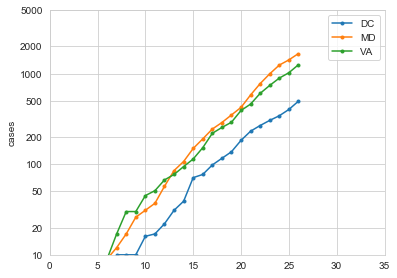

In [3]:

fig, ax = plt.subplots(figsize=r_[1,0.75]*6)


def plot_state(state='DC'):
    desIx = ctDf.state == state
    ys = ctDf.loc[desIx,'positive']
    dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
    xs = (dtV - dtV.iloc[-1])
    ctDf.loc[desIx,'day0'] = xs
    xs = [x.days for x in xs]


    ax.plot(xs, ys, marker='.', label=state)
    ax.set_yscale('log')
    ax.set_ylabel('cases')


plot_state('DC')
plot_state('MD')
plot_state('VA')

ax.set_ylim([10,2000])
yt = [10,20,50,100,200,500,1000,2000,5000]
plt.yticks(yt,yt)
#ax.set_yticklabels(['%d'%x for x in yt])
ax.set_xlim([0,35])

plt.legend()


## Times for deaths / cases to double
These plots will look prettier as this goes on. They're pretty choppy right now. 

In [4]:
def timeToDouble(state, countType): 
    df = ctDf[ctDf['state'] == state]
    df = df.fillna(0)
    df = df[df[countType] != 0]
    df = df.sort_values('date')
    df = df.reset_index(drop = True)
    doubleTime = [0]
    dates = []
    df = df.sort_values('date')
    df = df.reset_index(drop = True)
    start = df[countType].iloc[0]
    for (tIndex), tRow in df.iterrows():
        if (tRow[countType] >= start*2) == True:
            doubleTime.append(tIndex)
            dates.append(tRow.date)
            start = tRow[countType]
    double = np.diff(doubleTime)
    return(double, dates)

In [5]:
def plotDouble(state, countType, color): 
    double, dates = timeToDouble(state, countType)
    ax.plot(dates, double, marker='.', label=state, color = color, lw = 2)
    ax.set_ylabel('cases')

#### Time for positive cases to double

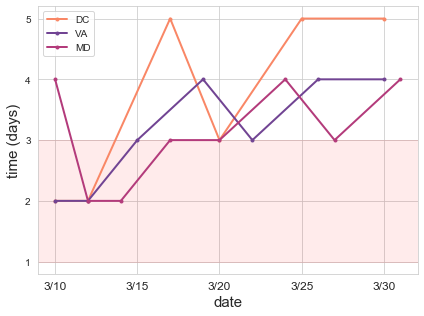

In [6]:
sns.set_style('whitegrid') 
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
plotDouble('DC', 'positive', color = '#f98766')
plotDouble('VA', 'positive', color = '#714493')
plotDouble('MD', 'positive', color = '#b33b7b')

plt.axhspan(1, 3, color = 'red', alpha = 0.08)

plt.xticks([20200310, 20200315, 20200320, 20200325, 20200330], 
           ['3/10', '3/15', '3/20', '3/25', '3/30'], fontsize = 12)
plt.yticks([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
plt.ylabel('time (days)', fontsize = 15)
plt.xlabel('date', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.savefig(figOutDir / 'doubleTimeCases.pdf', dpi = 300)

#### Time for deaths to double

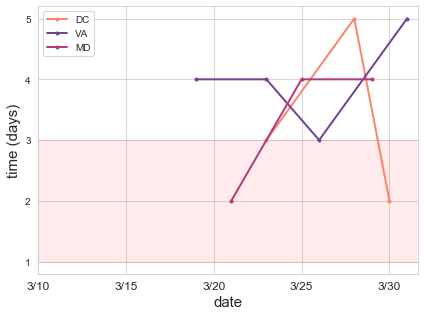

In [7]:
sns.set_style('whitegrid') 
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
plotDouble('DC', 'death', color = '#f98766')
plotDouble('VA', 'death', color = '#714493')
plotDouble('MD', 'death', color = '#b33b7b')

plt.axhspan(1, 3, color = 'red', alpha = 0.08)

plt.xticks([20200310, 20200315, 20200320, 20200325, 20200330], 
           ['3/10', '3/15', '3/20', '3/25', '3/30'], fontsize = 12)
plt.yticks([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
plt.ylabel('time (days)', fontsize = 15)
plt.xlabel('date', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.savefig(figOutDir / 'doubleTimeDeaths.pdf', dpi = 300)

## Positive cases / deaths over time (from day of first testing) 

In [8]:
DMV = ctDf[(ctDf['state'] == 'DC') | (ctDf['state'] == 'MD') | (ctDf['state'] == 'VA')]
DMV['day0'] = DMV['day0'] / pd.to_timedelta(1, unit='D')

#### Positive cases over time (log)

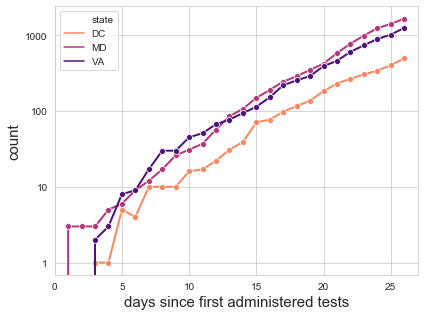

In [9]:
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
sns.set_style('whitegrid') 
sns.lineplot('day0', 'positive', data = DMV, hue = 'state', palette = 'magma_r', lw = 2, ms=12, marker='.', ls='-')
plt.yscale('log')
plt.xlabel('days since first administered tests', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
plt.xlim(0,len(DMV['day0'].unique()))
plt.tight_layout()
plt.savefig(figOutDir/'posCasesLog.pdf', dpi = 300)

#### Deaths over time (log)

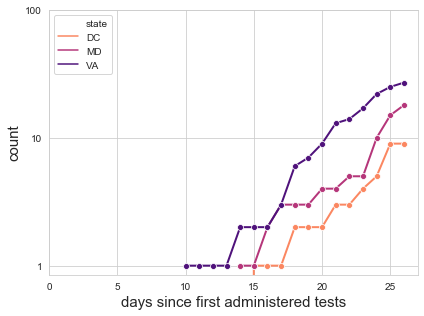

In [10]:
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
sns.lineplot('day0', 'death', data = DMV, hue = 'state', palette = 'magma_r', lw = 2, ms=12, marker='.', ls='-')
plt.yscale('log')
plt.xlabel('days since first administered tests', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.yticks([1, 10, 100], [1, 10, 100])
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.xlim(0,len(DMV['day0'].unique()))
plt.savefig(figOutDir / 'posDeathsLog.pdf', dpi = 300)


## Total tests over time, for kicks 
Maryland was lagging, man... 

([<matplotlib.axis.YTick at 0x120103350>,
 <a list of 5 Text yticklabel objects>)

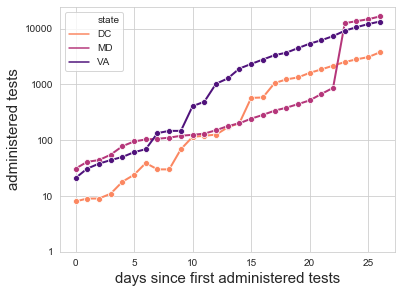

In [11]:
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
sns.lineplot('day0', 'total', data = DMV, hue = 'state', palette = 'magma_r', lw = 2, ms=12, marker='.', ls='-')
plt.yscale('log')
plt.xlabel('days since first administered tests', fontsize = 15)
plt.ylabel('administered tests', fontsize = 15)
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])

([<matplotlib.axis.YTick at 0x12035cdd0>,
 <a list of 5 Text yticklabel objects>)

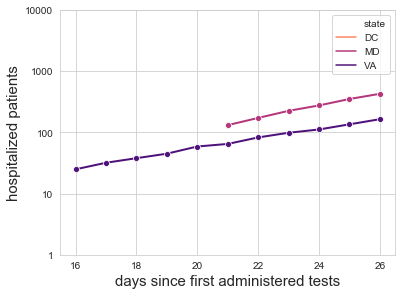

In [12]:
fig, ax = plt.subplots(figsize=r_[1,0.75]*6)
sns.lineplot('day0', 'hospitalized', data = DMV, hue = 'state', palette = 'magma_r', lw = 2, ms=12, marker='.', ls='-')
plt.yscale('log')
plt.xlabel('days since first administered tests', fontsize = 15)
plt.ylabel('hospitalized patients', fontsize = 15)
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])